# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified deterministic model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

### Load required packages

In [1]:
import random
import os
import numpy as np
import json
import corner
import random

import pandas as pd
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt
import datetime

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

### Scrape high-level Sciensano data

In [3]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-09-17,371,69,48,44,629,1.0,0.0,0.0,0.0,1.0,0.0
2020-09-18,390,78,46,54,621,5.0,0.0,0.0,1.0,1.0,3.0
2020-09-19,417,78,54,37,638,6.0,0.0,1.0,1.0,2.0,2.0
2020-09-20,428,77,48,20,666,1.0,0.0,0.0,0.0,1.0,0.0
2020-09-21,486,87,63,12,717,0.0,0.0,0.0,0.0,0.0,0.0


### Initialize the model without time-dependent parameters

In [3]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}

In [4]:
model = models.COVID19_SEIRD(initial_states, params)

### Calibrating $\beta$ and lag_time

**Go to next section if posterior samples are available**

Use the function `fit_pso` to obtain a good starting estimate for the MCMC sampler.

In [6]:
# define dataset
data=[df_sciensano["H_in"].values[:8]]
# set optimisation settings
parNames = ['sigma_H_in','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(30,60),(0.02,0.06)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=50,popsize=100)

No constraints given.
Best after iteration 1: [6.57351147e+01 4.34390823e+01 4.41820392e-02] 35.30416171797986
Best after iteration 2: [6.57351147e+01 4.34390823e+01 4.41820392e-02] 35.30416171797986
New best for swarm at iteration 3: [4.19504474e+01 4.88144660e+01 3.92560828e-02] 33.21548342287845
Best after iteration 3: [4.19504474e+01 4.88144660e+01 3.92560828e-02] 33.21548342287845
Best after iteration 4: [4.19504474e+01 4.88144660e+01 3.92560828e-02] 33.21548342287845
Best after iteration 5: [4.19504474e+01 4.88144660e+01 3.92560828e-02] 33.21548342287845
New best for swarm at iteration 6: [4.30484857e+01 4.87358833e+01 3.95800223e-02] 32.87819428157644
Best after iteration 6: [4.30484857e+01 4.87358833e+01 3.95800223e-02] 32.87819428157644
New best for swarm at iteration 7: [3.84413366e+01 5.79386791e+01 3.41544037e-02] 32.837513775724744
Best after iteration 7: [3.84413366e+01 5.79386791e+01 3.41544037e-02] 32.837513775724744
Best after iteration 8: [3.84413366e+01 5.79386791e+0

In [7]:
# Assign 'extraTime' or lag_time as a model attribute --> is needed to perform the optimalization
model.extraTime = int(round(theta[1]))
# Date of first data collection
start_date = '15-03-2020'

Initiatize and run the MCMC sampler

In [8]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.01,0.10))
# Initialise starting position of sampler based on PSO estimate
pos = [theta[0],theta[2]] + [1, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [07:32<00:00, 11.05it/s]


In [11]:
samples = sampler.get_chain(discard=50,flat=False)
flat_samples = sampler.get_chain(discard=50,flat=True)

In [12]:
# Calculate the autocorrelation time
try:
    print(sampler.get_autocorr_time())
except:
    print('The chain is shorter than 50 times the integrated autocorrelation time.')

[42.16939184 28.59529351]


In [13]:
# Calculate mean, percentile 10 and percentile 90 of samples
# index 1 = beta
print(np.mean(flat_samples[:,1]),np.percentile(flat_samples[:,1],10),np.percentile(flat_samples[:,1],90))

0.0374261730479394 0.03704498676158947 0.03777755441837192


Initialize a dictionary with the posterior samples and write them to `parameters_deterministic.json`

In [14]:
samples_dict={'lag_time': int(round(theta[1])), 'beta': flat_samples[:,1].tolist()}

In [15]:
with open('../data/interim/model_parameters/deterministic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'w') as fp:
    json.dump(samples_dict, fp)

Make a traceplot and cornerplot of the posterior samples

<AxesSubplot:xlabel='step number', ylabel='beta'>

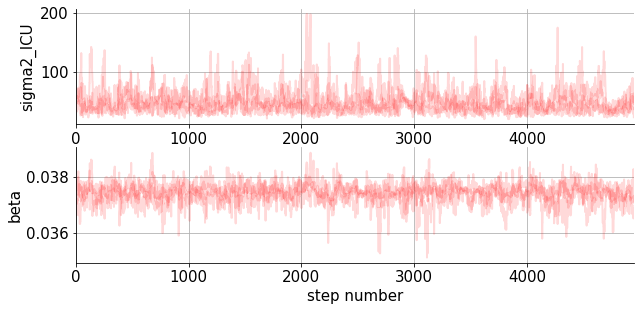

In [16]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

<ipython-input-17-1cae0a2f64ac>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('corner_beta.pdf', dpi=600, bbox_inches='tight',


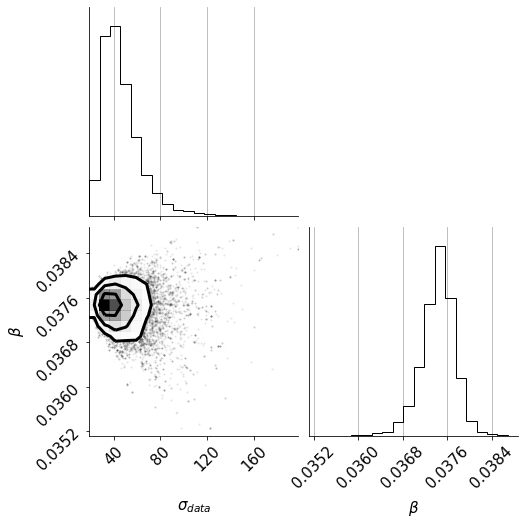

In [17]:
fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta$']
);
fig.set_size_inches(8, 8)
plt.savefig('corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

Make a visualisation of the data and model prediction

<ipython-input-20-d5eda4561876>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')


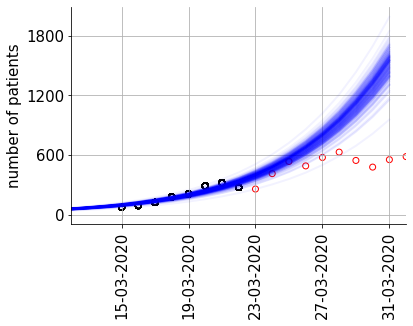

In [20]:
T = 9
fig,ax=plt.subplots()

for i in range(200):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][8:18].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][8:18], marker='o',color='red',linestyle='None',facecolors='none')
plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Calibrating the compliance ramp parameters

In [23]:
# Load previous samples
with open('../data/interim/model_parameters/deterministic_2020-09-23.json', 'r') as fp:
    samples_dict = json.load(fp)

Define the social policy change + two parameter ramp compliance

In [24]:
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return ((1/l)*(t-policy_time) - (1/l*tau))*(prevention*policy2-policy1)
    else:
        return prevention*policy2

In [25]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}

Update the parameter dictionary

In [26]:
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': samples_dict['lag_time'],
              'l': 1,
              'tau': 5,
              'prevention': 0.5})

Initialize the model

In [27]:
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

Load the previously calibrated parameters.

In [28]:
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

In [29]:
samples_beta = {'beta': samples_dict['beta']}

Find an initial guess for the MCMC sampler by using PSO

In [30]:
# define dataset
data=[df_sciensano["H_in"].values[:37]]
# set optimisation settings
parNames = ['sigma_H_in','l','tau','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,200),(0.1,20),(0.1,20),(0,0.8)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,samples=samples_beta,maxiter=100,popsize=100)

No constraints given.
New best for swarm at iteration 1: [66.70134913  2.9929564   8.65596586  0.39275306] 174.73403869356184
Best after iteration 1: [66.70134913  2.9929564   8.65596586  0.39275306] 174.73403869356184
Best after iteration 2: [66.70134913  2.9929564   8.65596586  0.39275306] 174.73403869356184
Best after iteration 3: [66.70134913  2.9929564   8.65596586  0.39275306] 174.73403869356184
Best after iteration 4: [66.70134913  2.9929564   8.65596586  0.39275306] 174.73403869356184
New best for swarm at iteration 5: [61.75087921  1.27929571  8.12965631  0.31076302] 167.52121397874
Best after iteration 5: [61.75087921  1.27929571  8.12965631  0.31076302] 167.52121397874
Best after iteration 6: [61.75087921  1.27929571  8.12965631  0.31076302] 167.52121397874
Best after iteration 7: [61.75087921  1.27929571  8.12965631  0.31076302] 167.52121397874
Best after iteration 8: [61.75087921  1.27929571  8.12965631  0.31076302] 167.52121397874
Best after iteration 9: [61.75087921  1.2

Best after iteration 73: [54.6133391   1.22288368  7.80623577  0.29820076] 166.27067779678544
Best after iteration 74: [54.6133391   1.22288368  7.80623577  0.29820076] 166.27067779678544
Best after iteration 75: [54.6133391   1.22288368  7.80623577  0.29820076] 166.27067779678544
Best after iteration 76: [54.6133391   1.22288368  7.80623577  0.29820076] 166.27067779678544
Best after iteration 77: [54.6133391   1.22288368  7.80623577  0.29820076] 166.27067779678544
Best after iteration 78: [54.6133391   1.22288368  7.80623577  0.29820076] 166.27067779678544
Best after iteration 79: [54.6133391   1.22288368  7.80623577  0.29820076] 166.27067779678544
Best after iteration 80: [54.6133391   1.22288368  7.80623577  0.29820076] 166.27067779678544
Best after iteration 81: [54.6133391   1.22288368  7.80623577  0.29820076] 166.27067779678544
Best after iteration 82: [54.6133391   1.22288368  7.80623577  0.29820076] 166.27067779678544
Best after iteration 83: [54.6133391   1.22288368  7.8062357

In [31]:
model.parameters.update({
    'l': theta[1],
    'tau': theta[2],
    'prevention': theta[3]
}
)

Initialize and run the MCMC sampler

In [32]:
bounds=((1,100),(0.001,20),(0,20),(0,1)) # must be a list!
pos = theta + [1, 0.1, 0.1, 0.1 ]* np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,samples_beta))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [21:41<00:00,  3.84it/s]


In [35]:
# Calculate the autocorrelation time
try:
    print(sampler.get_autocorr_time())
except:
    print('The chain is shorter than 50 times the integrated autocorrelation time.')

The chain is shorter than 50 times the integrated autocorrelation time.


In [36]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

Append posterior samples to the samples dictionary

In [37]:
samples_dict.update({'l': flat_samples[:,1].tolist(),'tau':flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist()})

In [39]:
with open('../data/interim/model_parameters/deterministic_'+ datetime.datetime.today().strftime('%Y-%m-%d')+'.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [40]:
# Calculate mean, percentile 10 and percentile 90 of samples
# index 0 --> sigma_{data}
# index 3 --> prevention
print(np.mean(flat_samples[:,1]),np.percentile(flat_samples[:,1],10),np.percentile(flat_samples[:,1],90))

1.1472001546582709 0.1941578191000642 2.1910886593917143


<AxesSubplot:xlabel='step number', ylabel='prevention'>

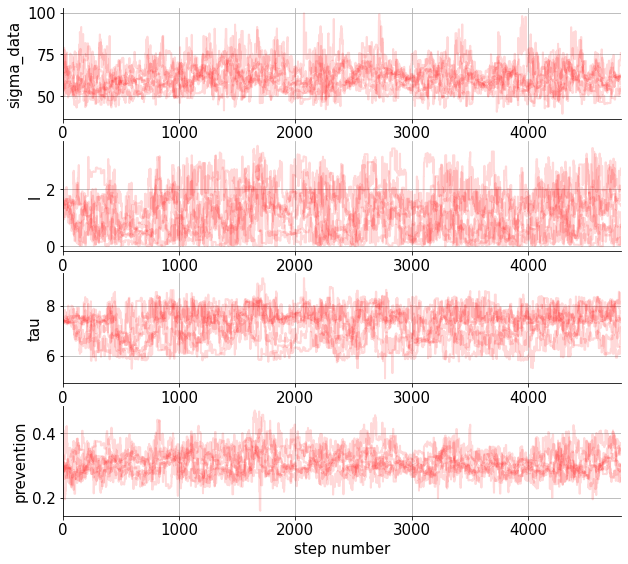

In [41]:
traceplot(samples=sampler.get_chain(discard=200),labels=["sigma_data","l","tau","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

<ipython-input-42-31533e70aca6>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',


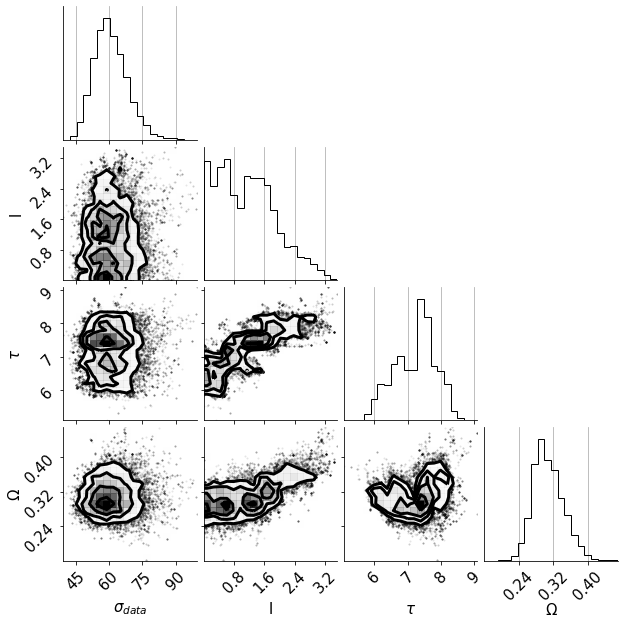

In [42]:
fig = corner.corner(
    flat_samples, labels=["$\sigma_{data}$","l","$\\tau$","$\Omega$"],
);
fig.set_size_inches(9, 9)
plt.savefig('corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [44]:
from covid19model.models.compliance import ramp_2

<ipython-input-45-b3c0aa7a7c37>:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')


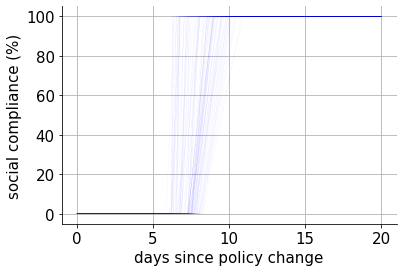

In [45]:
fig,ax=plt.subplots()
t = np.linspace(0,20,400)
for i in range(100):
    idx,l= random.choice(list(enumerate(flat_samples[:,1])))
    tau = samples_dict['tau'][idx]
    y=[]
    for j in range(len(t)):
        y.append(100*ramp_2(t[j],0,1,l,tau))
    ax.plot(t,y,color='blue',linewidth=0.1,alpha=0.2)
ax.set_xlabel('days since policy change')
ax.set_ylabel('social compliance (%)')
plt.savefig('compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

<ipython-input-48-f9e333d833ae>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')


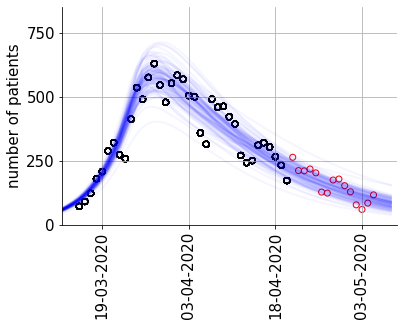

In [48]:
T = 18
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(100):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(flat_samples[:,1])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.04})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][37:52].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][37:52], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Computation of the basic reproduction number

2.911659336496132 2.8820040306177193 2.938995897105205


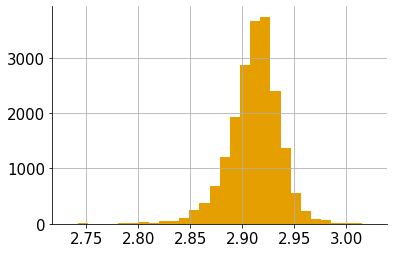

In [49]:
R_0 =[]
for i in range(len(samples_dict['beta'])):
    R_0.append(sum((model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)*(initN/sum(initN))))

plt.hist(R_0,bins=30)
mean = np.mean(R_0)
p10 = np.percentile(R_0,10)
p90 = np.percentile(R_0,90)
print(mean,p10,p90)

1.6663431936129363 1.6493714564026107 1.6819879124633679
2.0413824540937733 2.0205909348620525 2.060548286608296
4.493083814903932 4.447321670549274 4.53526782197104
5.269754393534387 5.216081844522374 5.319230291544879
4.140868289334886 4.098693466826212 4.1797454668764775
3.0415860020917878 3.010607390646096 3.070142399144043
1.5035134874073188 1.4882001738604667 1.5176294545673126
0.851602715926988 0.8429291260220324 0.8595981187431717
0.9437550424145336 0.934142879306614 0.9526156314929692


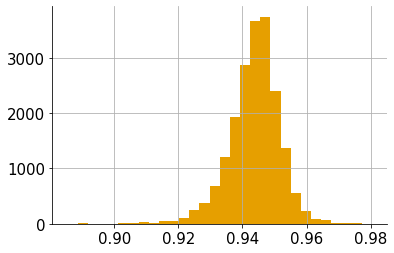

In [50]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)

### Visualisations used in the preprint

Load the posterior samples

In [51]:
with open('../data/interim/model_parameters/deterministic_2020-09-23.json', 'r') as fp:
    samples_dict = json.load(fp)

model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
model.parameters['prevention'] = np.mean(samples_dict['prevention'])

#### Cumulative hospitalizations

<ipython-input-56-c3a6f4a64729>:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('hospital_age.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')


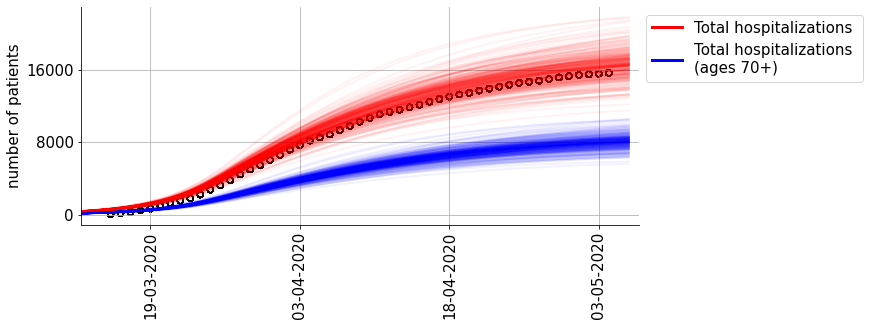

In [56]:
from covid19model.visualization.output import _apply_tick_locator

# define dataset
data=[df_sciensano["H_in"].values[:51]]
states = [["H_in"]]
start_date = '15-03-2020'

T = 2

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    
    # Create shifted index vector 
    idx = pd.date_range(start_date,freq='D',periods=data[0].size + samples_dict['lag_time'] + T) - datetime.timedelta(days=samples_dict['lag_time'])
    # Plot model prediction

    lines = ax.plot([],[],color='red',alpha=1)
    lines = ax.plot([],[],color='blue',alpha=1)
    
    for i in range(len(data)): 
        # ages 70 plus
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values[:,7:,:].sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='blue',linewidth= 2,alpha= 0.05)    
        # total cumsum
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values.sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='red',linewidth= 2,alpha= 0.05)  
    # Plot data
    for i in range(len(data)):
        lines=ax.scatter(idx[samples_dict['lag_time']:-T],np.cumsum(data[i]),color="black",facecolors='none')
    
    # Format axes
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
        'rotation', 90)
    #fig.autofmt_xdate(rotation=90)
    ax.set_xlim( idx[samples_dict['lag_time']-3], pd.to_datetime(idx[-1]+ datetime.timedelta(days=1)))
    ax.set_ylabel('number of patients')

    # limit the number of ticks on the axis
    ax = _apply_tick_locator(ax)

legend_text=['Total hospitalizations','Total hospitalizations \n(ages 70+)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
fig.set_size_inches(10, 4)
plt.savefig('hospital_age.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Continuation of lockdown

In [57]:
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

In [59]:
# Define data as a list containing data timeseries
index = pd.date_range('15-03-2020',freq='D',periods = data[0].size + samples_dict['lag_time'] + T)
print(index[1],index[50],index[52],index[57],index[64],index[81],index[108],index[170])

2020-03-16 00:00:00 2020-05-04 00:00:00 2020-05-06 00:00:00 2020-05-11 00:00:00 2020-05-18 00:00:00 2020-06-04 00:00:00 2020-07-01 00:00:00 2020-09-01 00:00:00


<ipython-input-61-4ebc9d716b21>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('continued_lockdown.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')


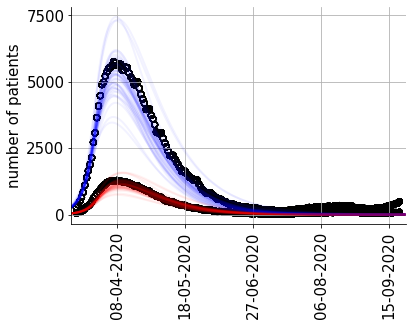

In [61]:
T = 3

fig,ax=plt.subplots()

for i in range(50):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,'15-03-2020',samples_dict['lag_time'],states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.05})

legend_text=['Hospital (total)','ICU (total)']
plt.savefig('continued_lockdown.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Lockdown release

In [62]:
def lockdown_release_func(t,param,policy_time,policy1,policy2,policy3,policy4,policy5,policy6,policy7,policy8,policy9,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return ((1/l)*(t-policy_time) - (1/l*tau))*(prevention*policy2-policy1)
    elif policy_time + tau + l < t <= policy_time + 50: 
        return prevention*policy2
    elif policy_time + 50 < t <= policy_time + 52:
        return prevention*policy3
    elif policy_time + 52 < t <= policy_time + 57:
        return prevention*policy4
    elif policy_time + 57 < t <= policy_time + 64:
        return prevention*policy5
    elif policy_time + 64 < t <= policy_time + 81:
        return prevention*policy6
    elif policy_time + 81 < t <= policy_time + 108:
        return prevention*policy7
    elif policy_time + 108 < t <= policy_time + 170:
        return prevention*policy8
    else:
        return prevention*policy9

In [63]:
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.15)*Nc_others + (1-0.85)*Nc_schools + (1-0.50)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.10)*Nc_others + (1-0.35)*Nc_schools + (1-0.30)*Nc_leisure,
              'policy8': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure,
              'policy9': 1.0*Nc_home + (1-0.10)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_schools + (1-0.00)*Nc_leisure,
               'policy_time': samples_dict['lag_time'],
              'l': 1,
              'tau': 5,
              'prevention': 0.5})

In [64]:
model_lr = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_release_func})

<ipython-input-65-6598df7673d4>:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('lockdown_release.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')


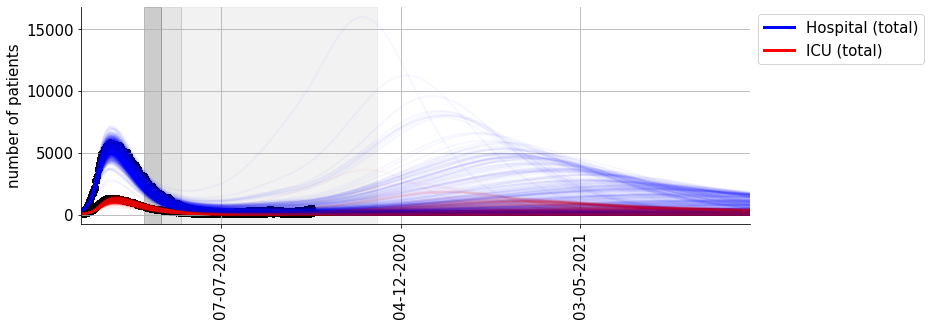

In [65]:
T = 365

fig,ax=plt.subplots()
fig.set_size_inches(12, 4)

ax.axvspan(index[50], index[64], alpha=0.20, color='black')
ax.axvspan(index[64], index[81], alpha=0.10, color='black')
ax.axvspan(index[81], index[-1], alpha=0.05, color='black')

for i in range(1000):
    model_lr.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model_lr.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model_lr.parameters['tau'] = samples_dict['tau'][idx]
    model_lr.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model_lr.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,'15-03-2020',samples_dict['lag_time'],states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.03})

legend_text=['Hospital (total)','ICU (total)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
plt.savefig('lockdown_release.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Seroprelevance

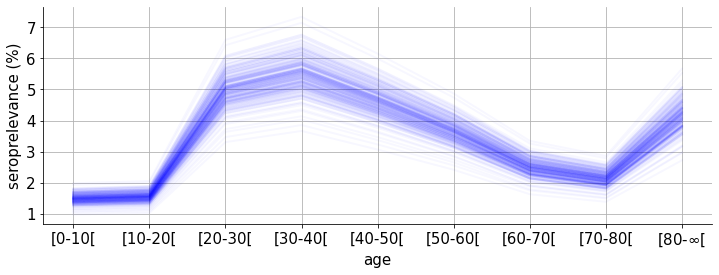

In [67]:
fig,ax=plt.subplots()
for i in range(200):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax.plot((1-y_model["S"][:,samples_dict['lag_time']+36]/y_model["S"][:,0])*100,alpha=0.03,color='blue',linewidth=2)
ax.set_xlabel('age')
ax.set_ylabel("seroprelevance (%)" )
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))
fig.set_size_inches(12, 4)

#### Basic reproduction number vs expected hospitalisations

1.6663431936129363 1.6493714564026107 1.6819879124633679
2.0413824540937733 2.0205909348620525 2.060548286608296
4.493083814903932 4.447321670549274 4.53526782197104
5.269754393534387 5.216081844522374 5.319230291544879
4.140868289334886 4.098693466826212 4.1797454668764775
3.0415860020917878 3.010607390646096 3.070142399144043
1.5035134874073188 1.4882001738604667 1.5176294545673126
0.851602715926988 0.8429291260220324 0.8595981187431717
0.9437550424145336 0.934142879306614 0.9526156314929692


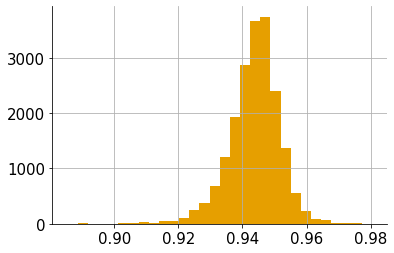

In [68]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

means=np.zeros(R_0.shape[0])
for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    means[i]=mean
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)

[ 0.03191037  0.07180383  1.27886268  4.9796856   7.88450858 16.74322819
 20.18235804 18.69750665 30.13013606]


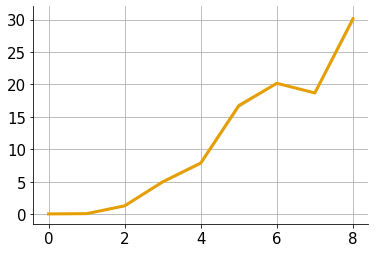

In [69]:
# define dataset
data=[df_sciensano["H_in"].values[:51]]
states = [["H_in"]]
start_date = '15-03-2020'

T = 2

fig,ax=plt.subplots()
n=100
csum_save=np.zeros([n,9])
for i in range(n):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    
    # Create shifted index vector 
    idx = pd.date_range(start_date,freq='D',periods=data[0].size + samples_dict['lag_time'] + T) - datetime.timedelta(days=samples_dict['lag_time'])

    # ages i plus
    data2plot = y_model[states[0]].to_array(dim="states").values.ravel()
    val = y_model[states[0]].to_array(dim="states").values[-1,:,:].sum(axis=1)
    #csum_iplus=np.cumsum(val)
    csum_iplus=val
    csum_save[i,:]=np.reshape((csum_iplus/sum(csum_iplus)),(1,(csum_iplus/sum(csum_iplus)).size))*100
    #csum_save[i,:] = csum_iplus/csum_iplus[-1]
print(csum_save.mean(axis=0))
csum_hosp_mean = csum_save.mean(axis=0)
csum_hosp_p10 = np.percentile(csum_save,10,axis=0)
csum_hosp_p90 = np.percentile(csum_save,90,axis=0)
plt.plot(np.arange(9),csum_hosp_mean)
plt.fill_between(np.arange(9),csum_hosp_p10,csum_hosp_p90,color='black',alpha=0.1)

<ipython-input-70-0d60c32cefe2>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('R_naught_cumulative_hospitalisations.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')


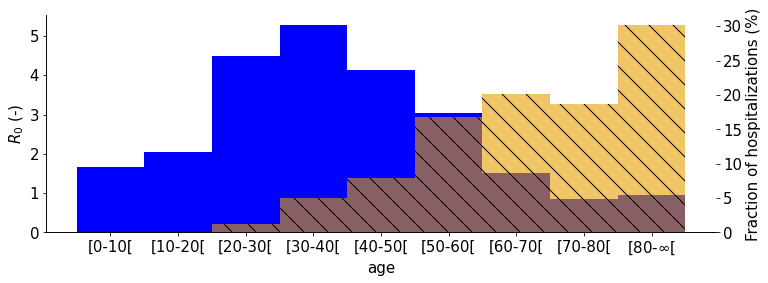

In [70]:
fig,ax1=plt.subplots()

ax1.bar(np.arange(R_0.shape[0]),means,1,color='blue')
ax1.set_xlabel('age')
ax1.set_ylabel('$R_0$ (-)')
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(np.arange(R_0.shape[0]),csum_hosp_mean,1,alpha=0.6,hatch="\\")
#ax2.plot(np.arange(R_0.shape[0]),csum_hosp_mean,'-s',markerSize=12)
ax2.set_xlabel('age')
ax2.set_ylabel('Fraction of hospitalizations (%)')
ax2.grid(False)
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))
fig.set_size_inches(12, 4)
plt.savefig('R_naught_cumulative_hospitalisations.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

### Re-estimating beta

In [58]:
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return ((1/l)*(t-policy_time) - (1/l*tau))*(prevention*policy2-policy1)
    else:
        return prevention*policy2

In [59]:
def beta_reestimate_func(t,param,change_beta_time,beta_old,beta_new):
    if t <= change_beta_time:
        return beta_old
    elif change_beta_time < t <= change_beta_time+120:
        return beta_new
    else:
        return beta_new

In [60]:
with open('../data/interim/model_parameters/deterministic_2020-09-23.json', 'r') as fp:
    samples_dict = json.load(fp)

In [61]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Add all time-dependent parameters to function definition
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': samples_dict['lag_time'],
              'l': np.mean(samples_dict['l']),
              'tau': np.mean(samples_dict['tau']),
              'prevention': np.mean(samples_dict['prevention']),
               'change_beta_time': np.mean(samples_dict['lag_time'])+50,
               'beta_old': np.mean(samples_dict['beta']),
               'beta_new': 0.06})
# Initialise the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func, 'beta': beta_reestimate_func})

In [62]:
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
model.parameters['prevention'] = np.mean(samples_dict['prevention'])

In [98]:
T = 62
from copy import deepcopy
# define dataset
data=[df_sciensano["H_in"].values[:]]
# Redine lag_time
model.extraTime = samples_dict['lag_time']
# define samples_dict without lag_time
smpls=deepcopy(samples_dict)
del smpls['lag_time']
# set optimisation settings
parNames = ['sigma_H_in','beta_new'] # must be a list!
states = [["H_in"]]
bounds=((1,500),(0.001,0.06)) # must be a list!

In [99]:
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,samples=smpls,maxiter=50,popsize=20)

No constraints given.
Best after iteration 1: [34.40910536  0.03542437] 798.4392535247795
Best after iteration 2: [34.40910536  0.03542437] 798.4392535247795
Best after iteration 3: [34.40910536  0.03542437] 798.4392535247795
Best after iteration 4: [34.40910536  0.03542437] 798.4392535247795
Best after iteration 5: [34.40910536  0.03542437] 798.4392535247795
Best after iteration 6: [34.40910536  0.03542437] 798.4392535247795
Best after iteration 7: [34.40910536  0.03542437] 798.4392535247795
Best after iteration 8: [34.40910536  0.03542437] 798.4392535247795
Best after iteration 9: [34.40910536  0.03542437] 798.4392535247795
Best after iteration 10: [34.40910536  0.03542437] 798.4392535247795
Best after iteration 11: [34.40910536  0.03542437] 798.4392535247795
New best for swarm at iteration 12: [4.14885021e+01 3.16444159e-02] 790.3202765743117
Best after iteration 12: [4.14885021e+01 3.16444159e-02] 790.3202765743117
New best for swarm at iteration 13: [3.48591177e+01 3.34147734e-02]

In [69]:
parNames = ['sigma_ICU','beta_new'] # must be a list!
bounds=((1,200),(0.0001,0.20))

pos = [theta[0],theta[1]] + [1, 1e-2 ]* np.random.randn(8, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,smpls))
sampler.run_mcmc(pos, 3000, progress=True);

100%|██████████| 3000/3000 [37:42<00:00,  1.33it/s]


In [75]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [76]:
sampler.get_autocorr_time()

array([41.03886554, 29.89718599])

In [77]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.07449218750825806 0.07194696267033891 0.07677643081673398


In [80]:
samples_dict.update({'beta_new': flat_samples[:,1].tolist()})

In [81]:
with open('../data/interim/model_parameters/deterministic_'+ datetime.datetime.today().strftime('%Y-%m-%d')+'.json', 'w') as fp:
    json.dump(samples_dict, fp)

<AxesSubplot:xlabel='step number', ylabel='beta_new'>

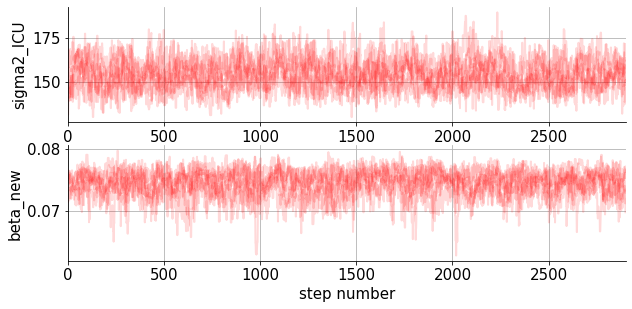

In [78]:
traceplot(samples,labels=["sigma2_ICU","beta_new"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

<ipython-input-79-a40bac863a50>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('corner_beta.pdf', dpi=600, bbox_inches='tight',


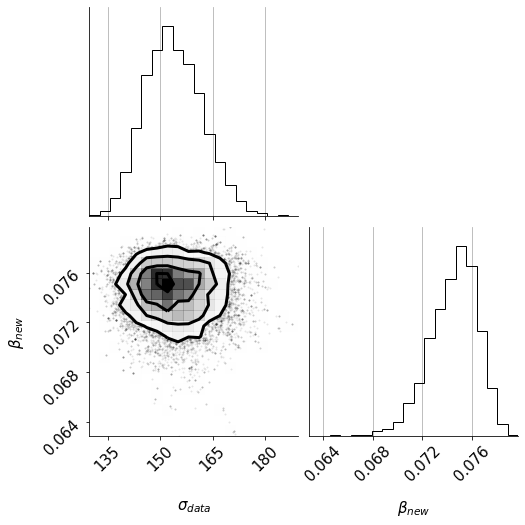

In [79]:
import corner

fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta_{new}$']
);
fig.set_size_inches(8, 8)
plt.savefig('corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [82]:
# define dataset
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

<ipython-input-95-e594f5b03bfc>:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')


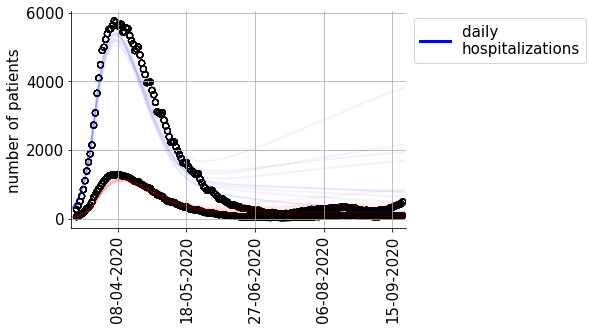

In [95]:
T = 1
start_date='15-03-2020'
#data=[df_sciensano["H_in"].values[:]]

fig,ax=plt.subplots()
for i in range(10):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    model.parameters['beta_new'] = np.random.choice(samples_dict['beta_new'],1,replace=False)

    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,T=T,ax=ax,plt_kwargs={'linewidth': 2,'alpha': 0.05})
    
#plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][:50].size),df_sciensano["H_in"][:50], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Re-compute the basic reproduction number

In [96]:
R_0 = (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*mean*model.parameters['s']*np.sum(Nc_total,axis=1)

In [97]:
print(R_0,np.mean(R_0))

[ 3.31665088  4.06312033  8.9429299  10.48879702  8.24188828  6.05390229
  2.9925584   1.69501031  1.87842817] 5.297031731061761
